<a href="https://colab.research.google.com/github/ourdanisalima/Steganographie_function/blob/main/nn_sad__and_happy_images(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [245]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import kagglehub
from PIL import Image
import os


In [246]:
import random
import numpy as np

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [247]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [248]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("saharnazyaghoobpoor/happy-and-sad-image")

#print("Path to dataset files:", path)

Using Colab cache for faster access to the 'happy-and-sad-image' dataset.


In [249]:
#afficher tous les images dans le path
i=0
for root, dirs, files in os.walk(path):
    for file in files:
        #print(os.path.join(root, file))
        i +=1

print(i)

175


In [250]:
#afficher le contenue du dossier data
dataset_path = path
data_dir = os.path.join(dataset_path, "data")

if os.path.exists(data_dir):
    files_in_data = os.listdir(data_dir)
    print("Contenu du dossier data :", files_in_data)
else:
    print("Le dossier 'data' n'existe pas.")

Contenu du dossier data : ['sad', 'happy']


In [251]:
# Chemin du dossier sad
sad_dir = os.path.join(dataset_path, "data/sad")
happy_dir = os.path.join(dataset_path, "data/happy")

# Lister toutes les images JPG/PNG
sad_images = [os.path.join(sad_dir, f) for f in os.listdir(sad_dir) if f.endswith((".jpg", ".png"))]
happy_images = [os.path.join(happy_dir, f) for f in os.listdir(happy_dir) if f.endswith((".jpg", ".png"))]
print("le nombre dimages sad :", len(sad_images))
print("le nombre dimages happy :", len(happy_images))


le nombre dimages sad : 68
le nombre dimages happy : 89


In [252]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20), # <--- Rotation pour simuler des têtes penchées
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)), # <--- Zoom et déformation
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [253]:
set_seed(42)

dataset = datasets.ImageFolder(
    root=path + "/data",  # dossier qui contient happy/ et sad/
    transform=transform
)

len(dataset), dataset.classes


(171, ['happy', 'sad'])

In [254]:
import torch

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Create a generator with a fixed seed for reproducible splits
generator = torch.Generator().manual_seed(42) # Using the same seed as set_seed

train_ds, test_ds = random_split(
    dataset,
    [train_size, test_size],
    generator=generator # Pass the generator here
)

len(train_ds), len(test_ds)

(136, 35)

In [255]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=16, shuffle=False)


In [256]:
class BetterCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            # CHANGE LE 3 EN 1 ICI
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2), # 128 -> 64

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2), # 64 -> 32

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2), # 32 -> 16
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),

            # Le calcul est 64 filtres * 16px * 16px
            nn.Linear(64 * 16 * 16, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# RÉ-INSTANCIE LE MODÈLE
model = BetterCNN().to(device)

In [257]:
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Correction du Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",    # Surveille la diminution de la perte
    factor=0.1,    # Réduit le LR par 10 (1e-4 -> 1e-5)
    patience=2    # Attend 2 époques sans amélioration avant de changer

)

In [258]:
def accuracy(loader):
    model.eval() # On passe en mode évaluation (désactive le dropout, etc.)
    correct = 0
    total = 0

    with torch.inference_mode():
        for x, y in loader:
            x, y = x.to(device), y.to(device)

            results = model(x)
            preds = results.argmax(dim=1) # On prend l'indice de la plus grande valeur

            correct += (preds == y).sum().item()
            total += y.numel()

    return correct / total

In [237]:
set_seed(42)
epochs = 20
train_loss_values = []
test_acc_values = []
best_test_acc = 0.0
best_state = None

print(f"Entraînement lancé sur : {device}")

for epoch in range(1, epochs + 1):
    # -- PHASE D'ENTRAÎNEMENT --
    model.train()
    running_loss = 0.0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad(set_to_none=True)
        preds = model(x)
        loss = loss_fn(preds, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * y.size(0)

    # -- CALCUL DES MÉTRIQUES (Important : avant le scheduler) --
    avg_loss = running_loss / len(train_loader.dataset)
    train_acc = accuracy(train_loader)
    test_acc  = accuracy(test_loader)

    # -- MISE À JOUR DU SCHEDULER (Correction ici) --
    # On passe la métrique 'avg_loss' car le scheduler est en mode 'min'
    scheduler.step(avg_loss)



    # -- SAUVEGARDE DU MEILLEUR MODÈLE --
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    # -- AFFICHAGE DES RÉSULTATS --
    train_loss_values.append(avg_loss)
    test_acc_values.append(test_acc)

    print(f"Epoch {epoch:02d} |  Loss: {avg_loss:.4f} | "
          f"Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f} | Best: {best_test_acc:.4f}")

# --- 3. RESTAURATION DU MEILLEUR MODÈLE ---
if best_state is not None:
    model.load_state_dict(best_state)
    model.to(device)
    print(f"\nTerminé ! Meilleure Accuracy Test atteinte : {best_test_acc:.4f}")

Entraînement lancé sur : cpu
Epoch 01 |  Loss: 0.7666 | Train Acc: 0.6324 | Test Acc: 0.4571 | Best: 0.4571
Epoch 02 |  Loss: 0.6402 | Train Acc: 0.6471 | Test Acc: 0.6857 | Best: 0.6857
Epoch 03 |  Loss: 0.6451 | Train Acc: 0.6324 | Test Acc: 0.7143 | Best: 0.7143
Epoch 04 |  Loss: 0.6096 | Train Acc: 0.5368 | Test Acc: 0.6571 | Best: 0.7143
Epoch 05 |  Loss: 0.5642 | Train Acc: 0.7868 | Test Acc: 0.7429 | Best: 0.7429
Epoch 06 |  Loss: 0.5718 | Train Acc: 0.8162 | Test Acc: 0.8000 | Best: 0.8000
Epoch 07 |  Loss: 0.5273 | Train Acc: 0.7941 | Test Acc: 0.8286 | Best: 0.8286
Epoch 08 |  Loss: 0.5193 | Train Acc: 0.7721 | Test Acc: 0.7429 | Best: 0.8286
Epoch 09 |  Loss: 0.5148 | Train Acc: 0.7941 | Test Acc: 0.7714 | Best: 0.8286
Epoch 10 |  Loss: 0.4958 | Train Acc: 0.8309 | Test Acc: 0.6571 | Best: 0.8286
Epoch 11 |  Loss: 0.5145 | Train Acc: 0.8456 | Test Acc: 0.7714 | Best: 0.8286
Epoch 12 |  Loss: 0.4861 | Train Acc: 0.8382 | Test Acc: 0.6857 | Best: 0.8286
Epoch 13 |  Loss: 0.467

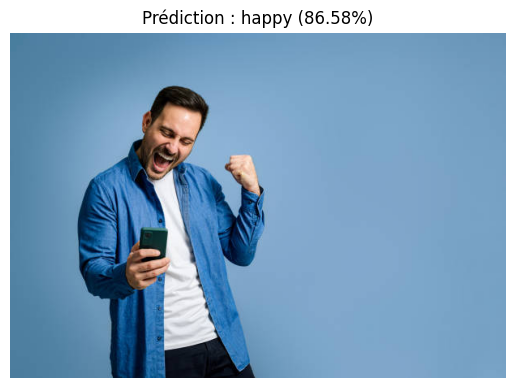

'happy'

In [238]:
import requests
from io import BytesIO
set_seed(42)
def predict_emotion(image_path):
    # 1. Charger l'image (Gestion URL vs Fichier local)
    if image_path.startswith('http'):
        response = requests.get(image_path)
        img = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        img = Image.open(image_path).convert('RGB')

    # 2. Transformation
    # On utilise le 'transform' que tu as défini (Resize + ToTensor)
    img_transformed = transform(img).unsqueeze(0).to(device)


    model.eval()
    with torch.inference_mode():
        output = model(img_transformed)

        probs = torch.softmax(output, dim=1)
        prediction = torch.argmax(output, dim=1).item()
        confiance = probs[0][prediction].item()


    class_names = dataset.classes
    result = class_names[prediction]


    plt.imshow(img)
    plt.title(f"Prédiction : {result} ({confiance:.2%})")
    plt.axis('off')
    plt.show()

    return result


url = "https://media.istockphoto.com/id/1473323104/fr/photo/bel-homme-mid-adulte-v%C3%AAtu-dune-chemise-en-jean-hurlant-et-pompant-joyeusement-le-poing-tout.jpg?s=612x612&w=0&k=20&c=asj80xwcm_lQfWJOoEWZ8tEFLPwI1RUqRNaMnYQfC5U="
predict_emotion(url)

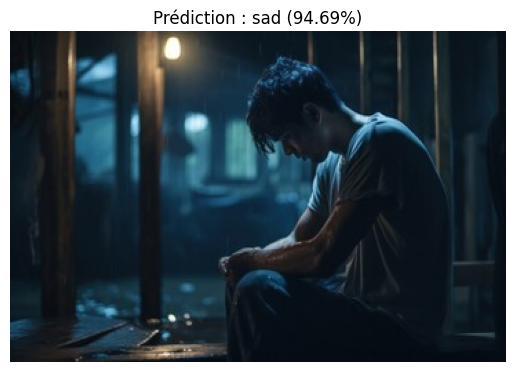

'sad'

In [239]:
import requests
from io import BytesIO
set_seed(42)
def predict_emotion(image_path):
    # 1. Charger l'image (Gestion URL vs Fichier local)
    if image_path.startswith('http'):
        # On ajoute des 'headers' pour simuler un navigateur
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(image_path, headers=headers)

        # Vérification si le téléchargement a réussi
        if response.status_code != 200:
            return f"Erreur : Impossible de charger l'image (Code {response.status_code})"

        img = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        img = Image.open(image_path).convert('RGB')

    # 2. Transformation
    # On utilise le 'transform' que tu as défini (Resize + ToTensor)
    img_transformed = transform(img).unsqueeze(0).to(device)

    # 3. Prédiction
    model.eval()
    with torch.inference_mode():
        output = model(img_transformed)
        probs = torch.softmax(output, dim=1)
        prediction = torch.argmax(output, dim=1).item()
        confiance = probs[0][prediction].item()

    # 4. Classes
    class_names = dataset.classes
    result = class_names[prediction]

    # 5. Affichage
    plt.imshow(img)
    plt.title(f"Prédiction : {result} ({confiance:.2%})")
    plt.axis('off')
    plt.show()

    return result

# Test avec ton nouveau lien
url = "https://t3.ftcdn.net/jpg/07/98/47/68/240_F_798476858_a79ChfQl7VcPDDJdeX1d42vqn0QQejJ0.jpg"
predict_emotion(url)

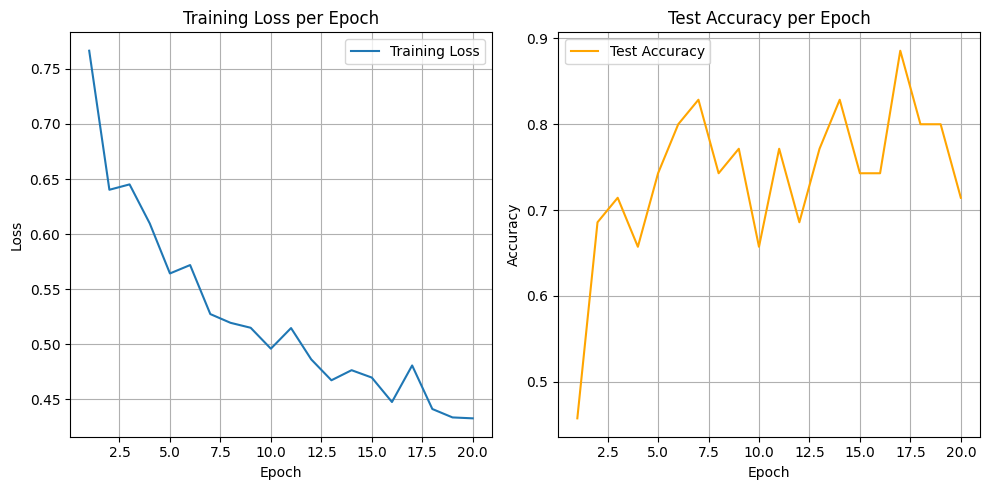

In [240]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(10, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_values, label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot test accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_acc_values, label='Test Accuracy', color='orange')
plt.title('Test Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**Testing**

In [242]:
import kagglehub

new_dataset_path = kagglehub.dataset_download("eneskosar19/happy-or-sad-binary-image-classification")

print("Path to new dataset files:", new_dataset_path)

Using Colab cache for faster access to the 'happy-or-sad-binary-image-classification' dataset.
Path to new dataset files: /kaggle/input/happy-or-sad-binary-image-classification


In [243]:
set_seed(42)

new_dataset = datasets.ImageFolder(
    root=new_dataset_path + "/face_classification",  # Corrected path for the new dataset
    transform=transform
)

print(f"New dataset length: {len(new_dataset)}")
print(f"New dataset classes: {new_dataset.classes}")

New dataset length: 164
New dataset classes: ['happy_person_face', 'sad_person_face']


Displaying predictions for 2 random images from the new dataset:

Sample 1: Original image path: /kaggle/input/happy-or-sad-binary-image-classification/face_classification/sad_person_face/bearded-guy-brown-coat-with-sad-face_1258-6716.jpg
Actual label: sad_person_face


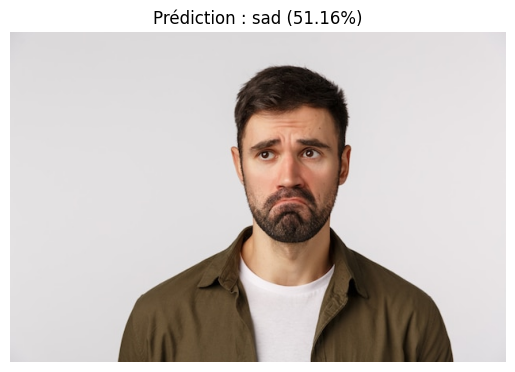


Sample 2: Original image path: /kaggle/input/happy-or-sad-binary-image-classification/face_classification/sad_person_face/ive-emotion-isolated-feeling-unhappy-crying-white-studio-background-90813316.jpg
Actual label: sad_person_face


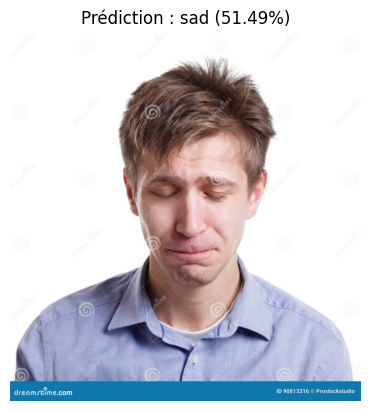

In [266]:
import random
set_seed(566)
# Number of samples to display
num_samples_to_test = 2

# Select random indices from the new dataset
sample_indices = random.sample(range(len(new_dataset)), num_samples_to_test)

print(f"Displaying predictions for {num_samples_to_test} random images from the new dataset:")

# Loop through the selected indices and predict emotion for each image
for i, idx in enumerate(sample_indices):
    # Get the image file path from the dataset
    # new_dataset.samples returns a list of (path, class_idx) tuples
    image_file_path = new_dataset.samples[idx][0]
    true_label_idx = new_dataset.samples[idx][1]
    true_label = new_dataset.classes[true_label_idx]

    print(f"\nSample {i+1}: Original image path: {image_file_path}")
    print(f"Actual label: {true_label}")

    # Call the predict_emotion function
    predicted_label = predict_emotion(image_file_path)
